To address the task of finding elements less than a given positive integer k in a list of integers using quantum computing, we have two distinct approaches. The first is a straightforward, albeit theoretically inspired method that leverages qubit states to flag numbers less than k. The second approach attempts to utilize Grover's algorithm, a quantum algorithm known for offering quadratic speedup for unstructured search problems. 

Approach 1: Direct Flagging with Quantum Circuit
Conceptual Overview :
This method involves using a qubit for each element in the given list. Each qubit is initialized to either ∣0⟩∣0⟩ or ∣1⟩∣1⟩ state, corresponding to whether the number at that index is greater than or equal to, or less than k, respectively. This is a purely quantum-inspired approach ratherthan a practical quantum algorithm application, as it does not leverage quantum computing's computational advantages.

These Programs are implemented in the IBM Quantum Lab and using Qiskit v1.0.2

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(token='e113bc80fd59aaf1380eef181825c013a3707ad76ec721bc9d55aed2092e8a67c2a8aad11d5675049ff7b002daf0a99de01ba0186761420d8c05ec336b05a02c', channel='ibm_quantum')


qiskit_runtime_service.__init__:INFO:2024-04-02 16:12:40,208: Default instance: ibm-q/open/main


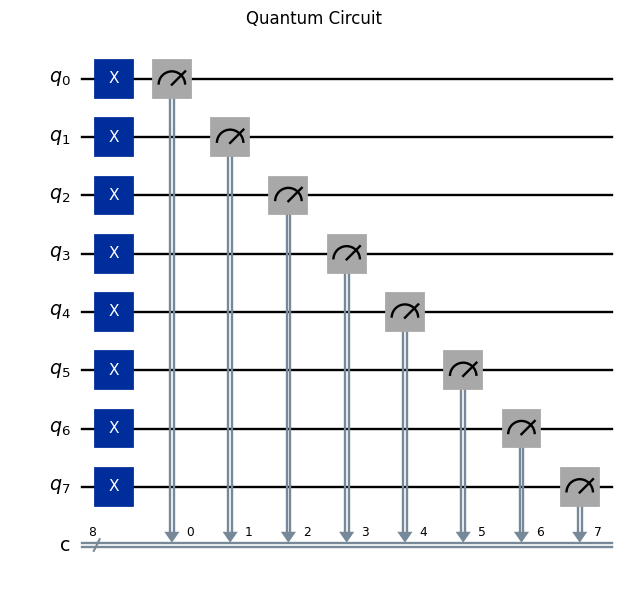

Numbers in the list less than 20: [4, 16, 11, 14, 1, 13, 6, 15]


In [2]:
from qiskit import QuantumCircuit, transpile, assemble
import math
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_aer import Aer

def find_less_than_k(k, num_list):
    flags = [num < k for num in num_list]
    qc = QuantumCircuit(len(num_list), len(num_list))
    
    for i, flag in enumerate(flags):
        if flag:
            qc.x(i)  # Flip qubit to |1> if number is less than k
    
    qc.measure(range(len(num_list)), range(len(num_list)))
    transpiled_qc = transpile(qc)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title("Quantum Circuit")
    qc.draw(output='mpl', ax=ax)
    plt.tight_layout()
    plt.show()
    
    simulator = Aer.get_backend('qasm_simulator')
    result = simulator.run(transpiled_qc).result()
    counts = result.get_counts()

    result_bin = list(counts.keys())[0]
    less_than_k_nums = [num_list[i] for i, bit in enumerate(reversed(result_bin)) if bit == '1']
    
    print(f"Numbers in the list less than {k}: {less_than_k_nums}")

# Example usage
k = 20
num_list = [4, 16, 11, 14, 1, 13, 6, 15]
find_less_than_k(k, num_list)


Approach 2: Grover's Algorithm for Finding Elements Less Than k
Conceptual Overview

Grover's algorithm provides a quadratic speedup for searching through unstructured databases. Adapting it to find elements less than k involves designing a quantum oracle that can "mark" states corresponding to numbers less than k in a superposition of all possible states. This marking is metaphorical; it involves applying a phase shift to those states. The subsequent steps amplify the probability amplitudes of the marked states, making them more likely to be observed upon measurement.

In [3]:
import math
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram

from qiskit_aer import Aer

def oracle(circuit, num_qubits, k):
    for qubit in range(num_qubits):
        if k & (1 << qubit):
            circuit.x(qubit)
    circuit.cz(0, num_qubits-1)
    for qubit in range(num_qubits):
        if k & (1 << qubit):
            circuit.x(qubit)

def grover_less_than_k(k, num_list):
    num_qubits = math.ceil(math.log2(max(num_list))) + 1  # Number of qubits needed

    qr = QuantumCircuit(num_qubits, num_qubits - 1)

    qr.h(range(num_qubits - 1))

    for num in num_list:
        if num < k:
            oracle(qr, num_qubits, num)

    # Diffusion operator (Amplify the good states and suppress the bad ones)
    qr.h(range(num_qubits - 1))  
    qr.x(range(num_qubits - 1)) 
    qr.h(num_qubits - 2)  
    qr.mcx(list(range(num_qubits - 2)), num_qubits - 2) 
    qr.h(num_qubits - 2) 
    qr.x(range(num_qubits - 1)) 
    qr.h(range(num_qubits - 1))  

    
    qr.measure(range(num_qubits - 1), range(num_qubits - 1))

    simulator = Aer.get_backend('qasm_simulator')
    transpiled_circuit = transpile(qr, simulator)

    job = simulator.run(transpiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(qr)

    # Filter results for elements less than k
    filtered_counts = {key: val for key, val in counts.items() if int(key, 2) < k}

  
    return filtered_counts

# Test the function
k = 6
num_list = [1, 2, 5, 4, 3, 13]
result = grover_less_than_k(k, num_list)
print("Unique elements less than {}: {}".format(bin(k)[2:], list(result.keys())))
print(result)


Unique elements less than 110: ['0100', '0101', '0010', '0000', '0011', '0001']
{'0100': 58, '0101': 70, '0010': 66, '0000': 64, '0011': 71, '0001': 65}


Direct Flagging Method
Practicality: This method is straightforward but does not utilize any quantum advantage. It essentially mirrors a classical computation on a quantum computer, which is not efficient or practical given the current state of quantum computing technology. The overhead of quantum computation and the lack of actual quantum speedup make this approach less appealing for practical purposes.

Adapting Grover's Algorithm
Practicality: Grover's algorithm is theoretically capable of providing a quadratic speedup for unstructured search problems. However, adapting it to perform comparisons (such as finding elements less than k) complicates the oracle construction significantly. The practicality of this approach hinges on the ability to design an efficient oracle, which is a non-trivial task and often requires custom solutions based on the problem's specifics.